In [1]:
%matplotlib inline

from misc import *

from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib
from scipy.special import logit
from theano import shared

import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb


In [2]:
#Load the survey data

index1 = preprocess(pd.read_excel('data/RawData/IN10001.xls'))
index4 = preprocess(pd.read_excel('data/RawData/IN10004.xls'))
index5 = preprocess(pd.read_excel('data/RawData/IN10005.xls'))
index6 = preprocess(pd.read_excel('data/RawData/IN10006.xls'))
index7 = preprocess(pd.read_excel('data/RawData/IN10007.xls'))

#Create a new dataframe that only contains the demographic information that's included in each survey

common_columns = list(set(index1.columns).intersection(set(index7.columns)))

common_data = pd.concat([index1[common_columns],
                         index4[common_columns],
                         index5[common_columns],
                         index6[common_columns],
                         index7[common_columns]
                        ])

#Drop the columns that don't contain demographic information

common_data.drop(['ID', 'ADID IDFA', 'Time Started', 'Time Finished'], axis=1, inplace=True)

#Drop the columns where area is missing since the distributions for each demographic doesn't differ much

index1 = index1.loc[index1['Area'] != 'Unknown', :]

#Get count of respondents by state

common_data.groupby(['Area']).size().reset_index().values


array([['Alabama', 122],
       ['Alaska', 3],
       ['Arizona', 110],
       ['Arkansas', 37],
       ['California', 536],
       ['Colorado', 52],
       ['Connecticut', 44],
       ['Delaware', 9],
       ['District of Columbia', 33],
       ['Florida', 380],
       ['Georgia', 196],
       ['Hawaii', 10],
       ['Idaho', 22],
       ['Illinois', 286],
       ['Indiana', 105],
       ['Iowa', 59],
       ['Kansas', 36],
       ['Kentucky', 154],
       ['Louisiana', 72],
       ['Maine', 23],
       ['Maryland', 112],
       ['Massachusetts', 68],
       ['Michigan', 279],
       ['Minnesota', 70],
       ['Mississippi', 47],
       ['Missouri', 111],
       ['Montana', 9],
       ['Nebraska', 39],
       ['Nevada', 36],
       ['New Hampshire', 14],
       ['New Jersey', 96],
       ['New Mexico', 13],
       ['New York', 305],
       ['North Carolina', 220],
       ['North Dakota', 4],
       ['Ohio', 331],
       ['Oklahoma', 77],
       ['Oregon', 57],
       ['Pennsylvania', 

In [3]:
#Encode whether or not a respodent will vote in the 2018 House of Representatives election

def will_vote(answer):
    if answer == "Won't Vote":
        return 0
    else:
        return 1

#Encode whether or not a respondent will vote for a major party candidate given that he/she will be voting
    
def will_vote_major(answer):
    if answer == 'Will vote Republican' or answer == 'Will vote Democratic':
        return 1
    else:
        return 0

#Encode which major party candidate a respondent will vote for given that he/she will be voting for a major party candidate
    
def which_major(answer):
    if answer == 'Will vote Republican':
        return 0
    elif answer == 'Will vote Democratic':
        return 1
    
def encode_demo(index):
    #Create separate LabelEncoder instances for each variable so that they can be used to perform inverse transformations on the results later

    gender_enc = LabelEncoder()
    race_enc = LabelEncoder()
    age_enc = LabelEncoder()
    area_enc = LabelEncoder()
    edu_enc = LabelEncoder()
    div_enc = LabelEncoder()

    race_gender_enc = LabelEncoder()
    age_edu_enc = LabelEncoder()
    age_gender_enc = LabelEncoder()
    edu_gender_enc = LabelEncoder()
    
    area_gender_enc = LabelEncoder()
    area_race_enc = LabelEncoder()
    area_age_enc = LabelEncoder()

    #Encode the gender, race, age, education, and state categories as integers

    index['Gender Encoded'] = gender_enc.fit_transform(index['Gender'])
    index['Race Encoded'] = race_enc.fit_transform(index['Race'])
    index['Age Encoded'] = age_enc.fit_transform(index['Age'])
    index['Area Encoded'] = area_enc.fit_transform(index['Area'])
    index['Education Encoded'] = edu_enc.fit_transform(index['Education'])
    index['Division Encoded'] = div_enc.fit_transform(index['US Census Division'])

    #Create new columns for the marginal categories

    index['Race_Gender'] = index['Race'].str.cat(index['Gender'], sep='|')
    index['Age_Education'] = index['Age'].str.cat(index['Education'], sep='|')
    index['Age_Gender'] = index['Age'].str.cat(index['Gender'], sep='|')
    index['Education_Gender'] = index['Education'].str.cat(index['Gender'], sep='|')
    
    index['Area_Gender'] = index['Area'].str.cat(index['Gender'], sep='|')
    index['Area_Race'] = index['Area'].str.cat(index['Race'], sep='|')
    index['Area_Age'] = index['Area'].str.cat(index['Age'], sep='|')

    #Encode the marginal categories as integers

    index['Race_Gender'] = race_gender_enc.fit_transform(index['Race_Gender'])
    index['Age_Education'] = age_edu_enc.fit_transform(index['Age_Education'])
    index['Age_Gender'] = age_gender_enc.fit_transform(index['Age_Gender'])
    index['Education_Gender'] = edu_gender_enc.fit_transform(index['Education_Gender'])
    
    index['Area_Gender'] = area_gender_enc.fit_transform(index['Area_Gender'])
    index['Area_Race'] = area_race_enc.fit_transform(index['Area_Race'])
    index['Area_Age'] = area_age_enc.fit_transform(index['Area_Age'])

    return index

#Perform one hot encoding on the possible answers for any given question

def ohe_question(index, question):
    col_name = ' '.join(question.split(' ')[:4])
    index = pd.concat([index1, pd.get_dummies(index1[question],
                                              prefix=col_name,
                                              prefix_sep='|')],
                      axis=1)
    
    return index


In [4]:
index1['Will Vote'] = index1['Who will you vote for in the House of Representatives in 2018?'].apply(lambda row: will_vote(row))
index1['Will Vote Major'] = index1['Who will you vote for in the House of Representatives in 2018?'].apply(lambda row: will_vote_major(row))
index1['Which Major'] = index1['Who will you vote for in the House of Representatives in 2018?'].apply(lambda row: which_major(row))

common_data = encode_demo(common_data)
index1 = encode_demo(index1)

question = 'How many of your close friends and family are studying at, or have graduated from, a four year college?'
index1 = ohe_question(index1, question)

In [5]:
#Group by race, gender, education, and age to see how many are in each cell and how many in each cell will vote

index1_unique = index1.groupby(['Gender Encoded',
                                'Age Encoded',
                                'Age_Gender'])["How many of your|Don't know"]
index1_unique = index1_unique.agg([("How many of your|Don't know", 'sum'), ('n', 'size')]).reset_index()


In [6]:
#Obtain a mapping from each state to its census division

division_map = common_data.groupby(['Area', 'US Census Division', 'Area Encoded', 'Division Encoded']).size().reset_index()[['Area', 'US Census Division', 'Area Encoded', 'Division Encoded']]

#Remove duplicate state rows where the census division is missing

division_map = division_map.loc[division_map['US Census Division'] != 'Unknown'].reset_index(drop=True)


In [7]:
#Load the 2016 Presidential Election results by state, taken from:
#https://www.dailykos.com/stories/2016/11/25/1601042/-Nerd-Alert-This-spreadsheet-contains-every-presidential-election-by-state-from-1828-to-2016


state_df = pd.read_csv('demographics/US Presidential Results & PVIs by State 1828-2016 - 2-Party US Pres Results & PVIs.csv',
                       header=1, usecols=[0, 2])
state_df.columns = ['Area', 'Trump Vote']

#Use the same name for District of Columbia in both dataframes

state_df.loc[state_df['Area'] == 'Washington DC', 'Area'] = 'District of Columbia'


#Join the 2016 Election results with the census divisions

state_df = state_df.merge(division_map)

#Calculate the log odds of the proportion of each state's voters that voted for Donald Trump in 2016

state_trump = logit(state_df['Trump Vote'].values/100)


In [8]:
#Create Theano constant variables for the demographic and marginal demographic variables

age = shared(index1_unique['Age Encoded'].values)
gender = shared(index1_unique['Gender Encoded'].values)

age_gender = shared(index1_unique['Age_Gender'].values)

#Create a Theano constant variable for the number of observations in each population cell

n = shared(index1_unique['n'].values)


In [9]:
index1_unique

,Gender Encoded,Age Encoded,Age_Gender,How many of your|Don't know,n
0,0,0,0,4,37
1,0,1,2,4,68
2,0,2,4,1,46
3,0,3,6,1,21
4,0,4,8,2,23
5,1,0,1,5,143
6,1,1,3,13,258
7,1,2,5,11,242
8,1,3,7,10,159
9,1,4,9,2,121


In [10]:
#Define the model for the state-level effects coefficient

def hierarchical_normal(name, shape, mu=0.0):
    delta = pm.Normal('delta_{}'.format(name), 0.0, 1.0, shape=shape)
    sigma = pm.HalfCauchy('sigma_{}'.format(name), 5.0)
    
    return pm. Deterministic(name, mu + delta*sigma)


In [15]:
"""
This section creates the general population variables.
======================================================

The intercept beta_0 uses an initial value for sampling that's equal to
the log odds of a respondent voting based on the survey responses.

Each of the general population demographic and marginal demographic
variables have a mean of 0 and a standard deviation of delta*sigma,
where delta is sampled from a normal distribution with a mean of 0
and standard deviation of 1, and sigma is sampled from a
half Cauchy distribution with beta = 5.

The variable eta is the multilevel logistic regression model that models
the log odds of the voter turnout rate.

"""

with pm.Model() as model:
    beta_0 = pm.Normal('beta_0', 0.0, 5.0,
                       testval=logit(index1["How many of your|Don't know"].values.mean()))
     
    alpha_age_gender = hierarchical_normal(name='age_gender',
                                           shape=index1['Age_Gender'].unique().size)

    alpha_age = hierarchical_normal(name='age',
                                    shape=index1['Age'].unique().size)
    alpha_gender = hierarchical_normal(name='gender',
                                       shape=index1['Gender'].unique().size)
    
    eta = (beta_0 +
           alpha_age_gender[age_gender] +
           alpha_age[age] +
           alpha_gender[gender])


In [16]:
#Define the observed random variables using a binomial distribution with a probability equal to eta

with model:
    p = pm.math.sigmoid(eta)
    obs = pm.Binomial('obs', n, p,
                      observed=index1_unique["How many of your|Don't know"].values)


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 36.66:  11%|█         | 21360/200000 [00:03<00:28, 6368.99it/s] 
Convergence archived at 21400
Interrupted at 21,399 [10%]: Average Loss = 162.01
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_gender_log__, delta_gender, sigma_age_log__, delta_age, sigma_age_gender_log__, delta_age_gender, beta_0]
100%|██████████| 2000/2000 [03:09<00:00, 10.55it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `ta

1.00133341082


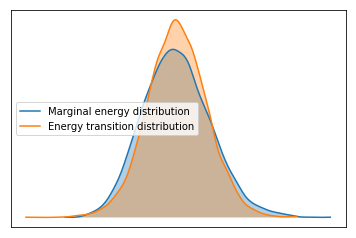

In [17]:
#Sample the model using ADVI as the initialization method for the NUTS sampler (the default setting will cause an error)

with model:
    trace = pm.sample(draws=1000,
                      tune=1000,
                      nuts_kwargs={'target_accept': 0.99},
                      init='advi+adapt_diag',
                      njobs=10)

joblib.dump(trace, 'trace_age_gender.pkl')
print(max(np.max(score) for score in pm.gelman_rubin(trace).values()))
pm.energyplot(trace)


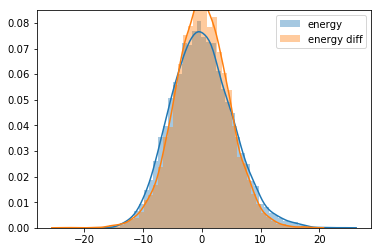

In [18]:
energy = trace['energy']
energy_diff = np.diff(energy)
sb.distplot(energy - energy.mean(), label='energy')
sb.distplot(energy_diff, label='energy diff')
plt.legend()


Number of Divergent 17
Percentage of Divergent 0.01700


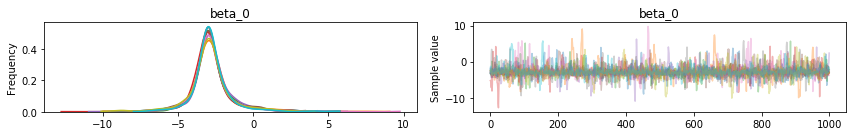

Number of Divergent 17
Percentage of Divergent 0.01700


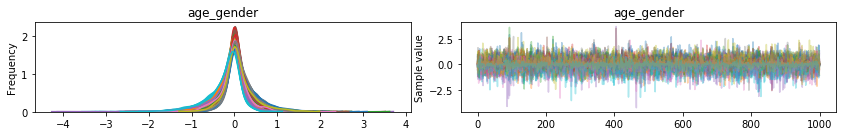

Number of Divergent 17
Percentage of Divergent 0.01700


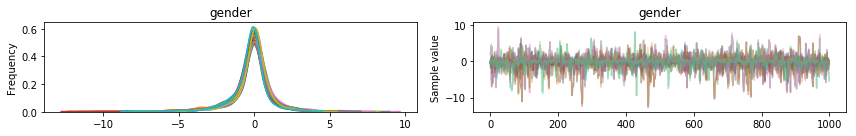

Number of Divergent 17
Percentage of Divergent 0.01700


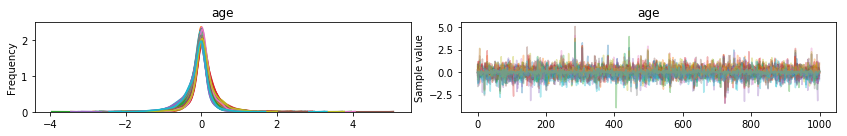

In [20]:
# Display the trace plot and density plot for each variable

model_vars = [beta_0,
              alpha_age_gender,
              alpha_gender,
              alpha_age]

for var in model_vars:
    pm.traceplot(trace, varnames=[var])
    
# Display the total number and percentage of divergent transitions

divergent = trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(trace)
print('Percentage of Divergent %.5f' % divperc)
    

100%|██████████| 1000/1000 [00:00<00:00, 2192.19it/s]


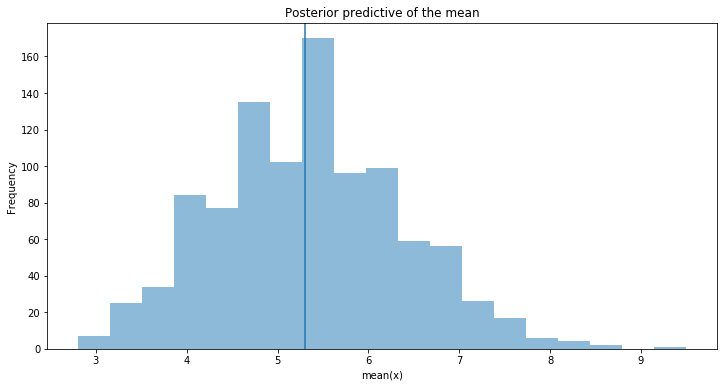

In [21]:
#Perform a posterior predictive check to ensure that the sample distribution overlaps with the dataset mean

ppc = pm.sample_ppc(trace, samples=1000, model=model)

_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in ppc['obs']], bins=19, alpha=0.5)
ax.axvline(index1_unique["How many of your|Don't know"].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');
